<center><img src="monai.png"/></center>

<p style="text-align: center">Welcome to the MONAI bootcamp!</p>
<p style="text-align: center">This notebook will introduce you to an end-to-end working in MONAI using a standard PyTorch loop.</center>

### Using Google Colab

This notebook has the pip command for installing MONAI and will be added to any subsequent notebook.

### Enabling GPU Support

To use GPU resources through Colab, change the runtime to GPU:

1. From the **"Runtime"** menu select **"Change Runtime Type"**
2. Choose **"GPU"** from the drop-down menu
3. Click **"SAVE"**

This will reset the notebook and probably ask you if you are a robot (these instructions assume you are not). Running



### Verify GPU Access

Running **!nvidia-smi** in a cell will verify this has worked and show you what kind of hardware you have access to.    

In [1]:
!nvidia-smi

Tue Jan 24 13:33:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:0B:00.0 Off |                    0 |
| N/A   21C    P0    33W / 250W |  29759MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Required Packages for Colab Execution

Execute the following cell to install MONAI the first time a colab notebook is run:

In [2]:
!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==1.1.0"

## End-to-end Training with Pytorch

We've covered a lot of material and now it's time to apply the things that we've learned in an end-to-end example using the basic Pytorch paradigm. We'll cover:

1. **Setting up our Dataset and exploring the data**
2. **Preparing datasets and transforms**
3. **Define your network and create our PyTorch training loop**
4. **Evaluate your model and understand the results**
5. **Later: use Ignite-based workflow classes to simplify process**

### Later: Bundles and Model Zoo

* MONAI Bundle format is a self-contained model package with pre-trained weights and all associated metadata abstracted through JSON and YAML-based configurations. By focusing on ease of use and flexibility, you can directly override or customize these configs or utilize a hybrid programming model that supports config to Python Code abstraction.

* Model Zoo provides pre-trained models as bundles. With these two components we hope to establish a common standard for reproducible research and collaboration. Everyone is welcome to contribute to this effort by submitting their pre-trained models for downstream tasks.

### Imports

Let's get started by importing our dependecies.

In [3]:
import os
import shutil
import tempfile
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
from torch.utils.data import DataLoader
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.data import decollate_batch, partition_dataset_classes
from monai.networks.nets import DenseNet121
from monai.transforms import (
    EnsureChannelFirst, Compose,LoadImage,RandFlip, RandRotate,
    RandZoom, ScaleIntensity, Activations, AsDiscrete, EnsureType
)
from monai.utils import set_determinism

/home/mzephyr/anaconda3/envs/monai_fix/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Setting up our Dataset and Exploring the Data

#### Setup data directory

We'll create a temporary directory for all the MONAI data we're going to be using called MONAI_DATA_DIRECTORY.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpc0ntfgs2


#### Download the MedNIST dataset
The `MedNIST` dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/). If you use the MedNIST dataset, please acknowledge the source.

Download this dataset and extract it into the temp directory:

In [5]:
resource = "https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

MedNIST.tar.gz: 59.0MB [00:02, 21.0MB/s]                              

2023-01-24 13:33:57,281 - INFO - Downloaded: /tmp/tmpc0ntfgs2/MedNIST.tar.gz


2023-01-24 13:33:57,364 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-01-24 13:33:57,365 - INFO - Writing into directory: /tmp/tmpc0ntfgs2.


#### Set deterministic training for reproducibility

[set_determinism](https://docs.monai.io/en/latest/utils.html?highlight=set_determinism#monai.utils.misc.set_determinism) will set the random seeds in both Numpy and PyTorch to ensure reproducibility. We'll see later that we need to go a little bit further to ensure reproducibility in a jupyter notebook.  For now, we'll also instanitate a seed value that we can use later.

In [6]:
set_determinism(seed=0)
rseed = 12345678

#### Read the image filenames from the dataset folders

When using a dataset, you want to understand the basics of the images, labels, and more.  We'll start off by showing some of those basic statistics for MedNIST. 

We'll then define our own `MedNISTDataset` class for illustrative purposes, although a more robust version is provided in MONAI.

MedNIST has 6 different folders representing 6 different categories: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT.  We'll be using each of these categories as our label names. 

In [7]:
subdirs = sorted(filter(os.path.isdir, glob(f"{data_dir}/*")))
class_names = list(map(os.path.basename, subdirs))
num_class = len(class_names)

image_files = [sorted(glob(f"{d}/*")) for d in subdirs]

num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = sum(image_files, [])
image_class = sum([[i] * n for i, n in enumerate(num_each)], [])

num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


#### Randomly pick images from the dataset to visualize and check

We want to understand what the images we're using look like, so we'll start by visualizing a few random images.

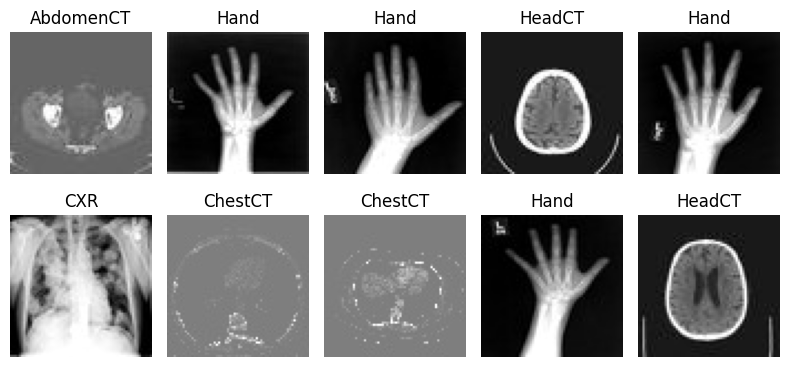

In [8]:
plt.subplots(2, 5, figsize=(8, 4),layout="tight")
for i, k in enumerate(np.random.randint(num_total, size=10)):
    im = PIL.Image.open(image_files_list[k])
    plt.subplot(2, 5, i + 1)
    plt.axis("off")
    plt.title(class_names[image_class[k]])
    plt.imshow(np.array(im), cmap="gray", vmin=0, vmax=255)

## 2. Preparing datasets and transforms

We want to split the data into 3 different sets, one for training, one for validation, and one for testing.  We'll use a ratio of 80/10/10 for those sets.

[MONAI Documentation](https://docs.monai.io/en/stable/)

<div class="alert alert-block alert-info">
    <b>Activity</b>

- Utilize the partition_dataset_classes function to properly split the dataset into parts
- Make sure you use the rseed variable from above in your partition_dataset_classes function to ensure reproducability
- We'll use an 80/10/10 split for the dataset
- Use the parts to create the new image lists and label lists
- Create new train, val, and test subsets, eaching having an image list (ie. `train_x`) and label list (`train_y`)

</div>

In [9]:
parts = partition_dataset_classes(
    data=np.arange(len(image_files_list)), 
    classes=image_class, 
    ratios=(8, 1, 1), 
    shuffle=True, 
    seed=rseed
)

image_sets = [list(), list(), list()]
label_sets = [list(), list(), list()]

for i, part in enumerate(parts):
    image_sets[i] = [image_files_list[idx] for idx in part]
    label_sets[i] = [image_class[idx] for idx in part]

train_x, val_x, test_x = image_sets
train_y, val_y, test_y = label_sets

print(f"Training count: {len(train_x)}, Validation count: {len(val_x)}, Test count: {len(test_x)}")

Training count: 47163, Validation count: 5895, Test count: 5895


#### Define MONAI transforms, Dataset and Dataloader to pre-process data

We'll define our transform sequence with `Compose`, in which we'll load the image, add a channel, scale its intensity, and utilize a few random functions.

[MONAI Documentation](https://docs.monai.io/en/stable/)

<div class="alert alert-block alert-info">
    <b>Activity</b>
    
Below you'll define the Compose trainsform train for the training data.  You'll need the following transforms:
    
- Load Image
- Ensure Channel First
- Scale Intensity
- Random Rotate, Flip, and Zoom

</div>

In [10]:
rseed = 12345678

train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=15, prob=0.5, keep_size=True).set_random_state(rseed),
        RandFlip(spatial_axis=0, prob=0.5).set_random_state(rseed),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5).set_random_state(rseed),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

act = Compose([Activations(softmax=True)])
to_onehot = Compose([AsDiscrete(to_onehot=num_class)])

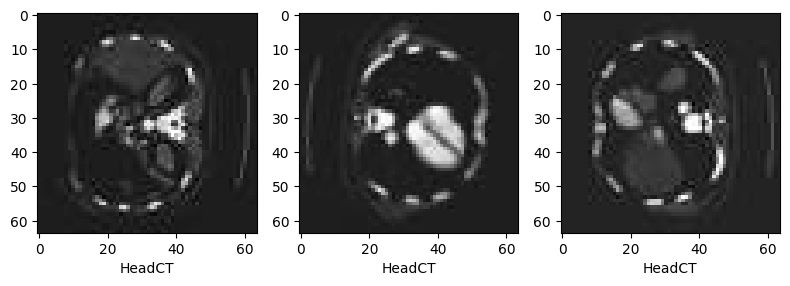

In [11]:
### Transform Test Functionality
plt.subplots(1, 3, figsize=(8, 8))
for i in range(0,3):
    test_output = train_transforms(image_files_list[i])
    #test_output = val_transforms(image_files_list[i])    
    
    arr = np.array(test_output[0])
    plt.subplot(1, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=1)
plt.tight_layout()
plt.show()

#### Initialise the datasets and loaders for training, validation and test sets
 * Define a simple dataset, that we'll call `MedNISTDataset`, that groups:
   * Images
   * Labels
   * The transforms that are to be run on the images and labels
 * Create three instances of this dataset:
   * One for training
   * One for validation
   * One for testing
   
We'll use a batch size of 512 and employ 10 workers to load the data.

In [12]:
batch_size = 512
num_workers = 10

class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)

#### Define network and optimizer

We'll make sure to set the relevant values for getting our device and instantiating our network, loss function and optimizer.

[MONAI Documentation](https://docs.monai.io/en/stable/)

<div class="alert alert-block alert-info">
    <b>Activity</b>
    
Do the following:
1. Get the device for a GPU from torch
2. Instantiate DenseNet121.  You'll need to set Spatial Dimension to 2 and Input Channels to 1 and output channels to the number of classes from our data exploration above.
3. Instantiate the Torch CrossEntropy Loss function
4. Instantiate the Torch  Adam Optimizer with a learning rate of 1e-5  
</div>

In [13]:
learning_rate = 1e-5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), learning_rate)

#### Network training
We are hand-rolling a basic pytorch training loop here:
 * standard pytorch training loop
   * step through each training epoch, running through the training set in batches
   * after each epoch, run a validation pass, evaluating the network
   * if it shows improved performance, save out the model weights
 * later we will revisit training loops in a more Ignite / MONAI fashion

In [16]:
epoch_num = 4
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
auc_metric = ROCAUCMetric()

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")

    epoch_loss = 0
    step = 1

    steps_per_epoch = len(train_ds) // train_loader.batch_size

    # put the network in train mode; this tells the network and its modules to
    # enable training elements such as normalisation and dropout, where applicable
    net.train()
    for batch_data in train_loader:

        # move the data to the GPU
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

        # prepare the gradients for this step's back propagation
        optimizer.zero_grad()
        
        # run the network forwards
        outputs = net(inputs)
        
        # run the loss function on the outputs
        loss = loss_function(outputs, labels)
        
        # compute the gradients
        loss.backward()
        
        # tell the optimizer to update the weights according to the gradients
        # and its internal optimisation strategy
        optimizer.step()

        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size + 1}, training_loss: {loss.item():.4f}")
        step += 1

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # after each epoch, run our metrics to evaluate it, and, if they are an improvement,
    # save the model out
    
    # switch off training features of the network for this pass
    net.eval()

    # 'with torch.no_grad()' switches off gradient calculation for the scope of its context
    with torch.no_grad():
        # create lists to which we will concatenate the the validation results
        preds = list()
        labels = list()

        # iterate over each batch of images and run them through the network in evaluation mode
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)

            # run the network
            val_pred = net(val_images)

            preds.append(val_pred)
            labels.append(val_labels)

        # concatenate the predicted labels with each other and the actual labels with each other
        y_pred = torch.cat(preds)
        y = torch.cat(labels)

        # we are using the area under the receiver operating characteristic (ROC) curve to determine
        # whether this epoch has improved the best performance of the network so far, in which case
        # we save the network in this state
        y_onehot = [to_onehot(i) for i in decollate_batch(y, detach=False)]        
        y_pred_act = [act(i) for i in decollate_batch(y_pred)]
        
        auc_metric(y_pred_act, y_onehot)
        auc_value = auc_metric.aggregate()
        auc_metric.reset()
        metric_values.append(auc_value)
        
        acc_value = torch.eq(y_pred.argmax(dim=1), y)
        acc_metric = acc_value.sum().item() / len(acc_value)
        
        if auc_value > best_metric:
            best_metric = auc_value
            best_metric_epoch = epoch + 1
            torch.save(net.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
            print("saved new best metric network")
            
        print(
            f"current epoch: {epoch + 1} current AUC: {auc_value:.4f} /"
            f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f} /"
            f" at epoch: {best_metric_epoch}"
        )

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/93, training_loss: 0.5757
2/93, training_loss: 0.5457
3/93, training_loss: 0.5096
4/93, training_loss: 0.5574
5/93, training_loss: 0.5178
6/93, training_loss: 0.5332
7/93, training_loss: 0.5015
8/93, training_loss: 0.5009
9/93, training_loss: 0.4952
10/93, training_loss: 0.5288
11/93, training_loss: 0.4782
12/93, training_loss: 0.5016
13/93, training_loss: 0.4651
14/93, training_loss: 0.4986
15/93, training_loss: 0.4805
16/93, training_loss: 0.4700
17/93, training_loss: 0.4468
18/93, training_loss: 0.4378
19/93, training_loss: 0.4693
20/93, training_loss: 0.4329
21/93, training_loss: 0.4650
22/93, training_loss: 0.4127
23/93, training_loss: 0.4075
24/93, training_loss: 0.4253
25/93, training_loss: 0.4386
26/93, training_loss: 0.4053
27/93, training_loss: 0.4103
28/93, training_loss: 0.4030
29/93, training_loss: 0.3886
30/93, training_loss: 0.3909
31/93, training_loss: 0.3858
32/93, training_loss: 0.3741
33/93, training_loss: 0.3813
34/93, training_loss: 0.3689
35

#### Plot the loss and metric

Once we're done training we want to visualize our Loss and Accuracy.

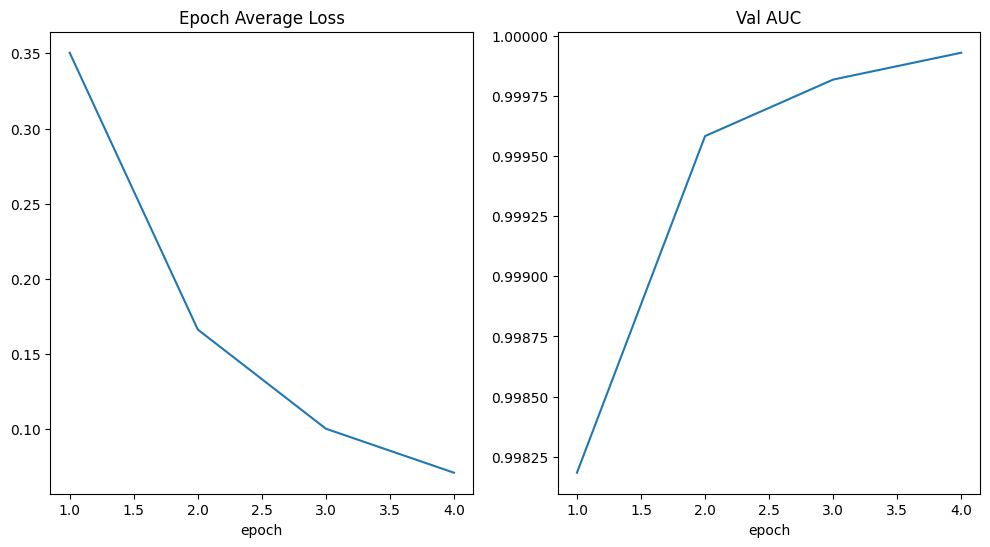

In [17]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [(i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## **4. Evaluate Your Model and Understand the Results**

After training and validation, we now have the best model as determined by the validation dataset.  But now we need to evaluate the model on the test dataset to check whether the final model is robust and not over-fitting.  We'll use these predictions to generate a classification report.

In [18]:
net.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
net.eval()
y_true = list()
y_pred = list()

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = net(test_images).argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

#### Some light analytics - classification report

We'll utilize scikit-learn's classification report to get the precision, recall, and f1-score for each category.

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9840    0.9820    0.9830      1000
   BreastMRI     0.9933    0.9911    0.9922       895
         CXR     0.9960    0.9910    0.9935      1000
     ChestCT     0.9930    1.0000    0.9965      1000
        Hand     0.9910    0.9860    0.9885      1000
      HeadCT     0.9841    0.9910    0.9875      1000

    accuracy                         0.9902      5895
   macro avg     0.9902    0.9902    0.9902      5895
weighted avg     0.9902    0.9902    0.9902      5895



#### Some light analytics - confusion matrix

Let's also create a confusion matrix to get a better understanding of the failure cases

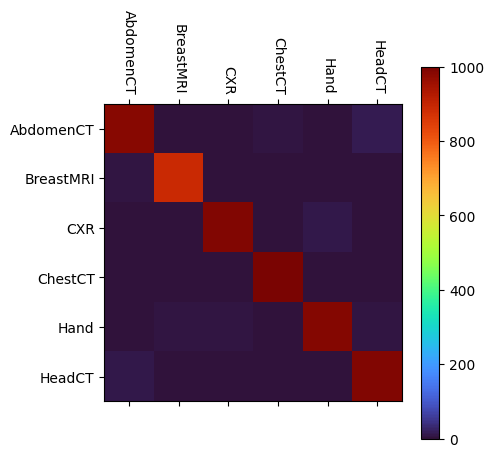

In [20]:
from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(y_true, y_pred)

cax = plt.matshow(cmat, cmap="turbo", interpolation="nearest")
plt.colorbar(cax)

cax.axes.set_xticks(list(range(len(class_names))), class_names, rotation=270)
cax.axes.set_yticks(list(range(len(class_names))), class_names)

plt.show()

## **Summary**

In this notebook, we went through an end-to-end workflow to train the MedNIST dataset using a densenet121 network.  Along the way, you did the following:
- Learned about the MedNIST Data and downloaded it
- Visualized the data to understand the images
- Setup the datasets for use in the model training
- Defined our transforms, datasets, network, and optimizers
- Trained a densenet model and saved the best model as determined by the validation accuracy
- Plotted your training results
- Evaluated your model against the test set
- Ran your final predictions through a classification report to understand more about your final results
- Created a new workflow using Ignite
- Learn more about issues with determinism and how to look out for pitfalls